In [1]:
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline


##Упражнение 1
- Скачайте с портала Открытых Данных производственный календарь России: https://data.gov.ru/opendata/7708660670-proizvcalendar
- На его основе определите соответствующий календарь в Pandas: RussianBusinessCalendar(AbstractHolidayCalendar)
- С помощью полученного в пункте выше календаря и модуля pd.offsets создайте DataFrame one-hot календарных признаков:
  - День недели
  - Месяц
  - Выходной день
  - Праздничный день
  - Предпраздничный рабочий день
  - Последний день месяца
  - Последний рабочий день месяца
  - Предновогодний выходной день

In [2]:
df = pd.read_csv('https://data.gov.ru/sites/default/files/data-20181017t0930-structure-20181017t0930_5.csv')
df.head()

,Год/Месяц,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Всего рабочих дней,Всего праздничных и выходных дней,Количество рабочих часов при 40-часовой рабочей неделе,Количество рабочих часов при 36-часовой рабочей неделе,Количество рабочих часов при 24-часовой рабочей неделе
0,1999,"1,2,3,4,6*,7,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25,30*","1,2,3,4,8,9,10,15,16,22,23,29,30","5,6,11*,12,13,14,19,20,26,27","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","2,3,9,10,16,17,23,24,30,31","6,7,8,13,14,20,21,27,28","4,5,11,12,13,18,19,25,26,31*",251,114,2004,1807.2,1204.8
1,2000,"1,2,3,4,6*,7,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","4,5,7*,8,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","1,2,6,7,8*,9,13,14,20,21,27,28","3,4,10,11,12,17,18,24,25","1,2,8,9,15,16,22,23,29,30","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,7,11,12,18,19,25,26","2,3,9,10,11*,12,16,17,23,24,30,31",250,116,1995,1800.0,1200.0
2,2001,"1,2,6,7,8,13,14,20,21,27,28","3,4,10,11,17,18,24,25","3,4,7*,8,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29,30*","1,2,5,6,8*,9,12,13,19,20,26,27","2,3,9,10,11*,12,16,17,23,24,30","1,7,8,14,15,21,22,28,29","4,5,11,12,18,19,25,26","1,2,8,9,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,6*,7,10,11,17,18,24,25","1,2,8,9,12,15,16,22,23,29,30",251,114,2001,1807.2,1204.8
3,2002,"1,2,5,6,7,12,13,19,20,26,27","2,3,9,10,16,17,22*,23,24,25","2,3,7*,8,9,10,16,17,23,24,30,31","6,7,13,14,20,21,28,30*","1,2,3,4,5,8*,9,10,11,12,19,25,26","1,2,8,9,11*,12,15,16,22,23,29,30","6,7,13,14,20,21,27,28","3,4,10,11,17,18,24,25,31","1,7,8,14,15,21,22,28,29","5,6,12,13,19,20,26,27","2,3,6*,7,8,9,16,17,23,24,30","1,7,8,11*,12,13,14,21,22,28,29,31*",250,115,1992,1792.0,1192.0
4,2003,"1,2,3,5*,6,7,11,12,18,19,25,26","1,2,8,9,15,16,22,23,24","1,2,7*,8,9,10,15,16,22,23,29,30","5,6,12,13,19,20,26,27,30*","1,2,3,4,8*,9,10,11,17,18,24,25,31","1,7,8,11*,12,13,14,15,22,28,29","5,6,12,13,19,20,26,27","2,3,9,10,16,17,23,24,30,31","6,7,13,14,20,21,27,28","4,5,11,12,18,19,25,26","1,2,6*,7,8,9,15,16,22,23,29,30","6,7,11*,12,13,14,20,21,27,28,31*",250,115,1992,1792.0,1192.0


In [3]:
# Плюсом (+) отмечены перенесенные выходные дни
days_off = []
# Звездочкой (*) отмечены предпраздничные (сокращенные) дни
pre_holidays = []
# Праздничные дни
holidays = ['01.01.00', '02.01.00', '03.01.00', '04.01.00', '05.01.00', '06.01.00', '07.01.00', '08.01.00', '23.02.00', '08.03.00', '01.05.00', '09.05.00', '12.06.00', '04.11.00']
months = ('Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь', 'Июль', 'Август', 'Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь')
last_holiday_in_year = []
for year in range(df.shape[0]):
  for num_month, month in enumerate(months):
    for day in df[month][year].split(','):
      if '*' in day:
        pre_holidays.append(f"{day[:-1]}, {num_month+1}, {df['Год/Месяц'][year]}")
      elif '+' in day:
        days_off.append(f"{day[:-1]}, {num_month+1}, {df['Год/Месяц'][year]}")
      else:
        days_off.append(f"{day}, {num_month+1}, {df['Год/Месяц'][year]}")
  last_holiday_in_year.append(days_off[-1])

In [4]:
days_off = pd.to_datetime(days_off, dayfirst=True).sort_values()
pre_holidays = pd.to_datetime(pre_holidays, dayfirst=True)
holidays = pd.to_datetime(holidays, dayfirst=True).strftime('%B %-d')
days_off[:10]

DatetimeIndex(['1999-01-01', '1999-01-02', '1999-01-03', '1999-01-04',
               '1999-01-07', '1999-01-09', '1999-01-10', '1999-01-16',
               '1999-01-17', '1999-01-23'],
              dtype='datetime64[ns]', freq=None)

In [5]:
# кастомизация календаря

from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, EasterMonday
from pandas.tseries.offsets import DateOffset, Day

class RussianBusinessCalendar(AbstractHolidayCalendar):
    start_date = datetime.datetime(1999, 1, 1)
    end_date = datetime.datetime(2025, 12, 31)
    rules = [Holiday('Days Off', month=i.month, day=i.day, year=i.year) for i in days_off]
    
russian_busday = pd.offsets.CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri', 
                                              calendar=RussianBusinessCalendar())

In [6]:
onehot_calendar = pd.DataFrame(index=pd.date_range(start='1999-01-01', end='2025-12-31', freq='D'))
# выходные
onehot_calendar['Выходной'] = list(map(int, [i in days_off for i in onehot_calendar.index]))

# праздники
onehot_calendar['Праздник'] = list(map(int, [i.strftime('%B %-d') in holidays for i in onehot_calendar.index]))

# Предпраздничные рабочие дни
pre_holidays = [datetime.datetime(i.year, i.month, i.day) + pd.Timedelta(days=1) - russian_busday for i in onehot_calendar[onehot_calendar['Праздник'] == 1].index]
onehot_calendar['Предпраздничный рабочий день'] = list(map(int, [i in pre_holidays for i in onehot_calendar.index]))

# Последний день месяца
last_days_of_month = [pd.to_datetime(str(year)) + pd.offsets.MonthEnd(i) for year in onehot_calendar.index.year.unique() for i in range(1, 13)]
onehot_calendar['Последний день месяца'] = list(map(int, [i in last_days_of_month for i in onehot_calendar.index]))

# Последний рабочий день месяца
last_workdays_of_month = [datetime.datetime(i.year, i.month, i.day) + pd.Timedelta(days=1) - russian_busday for i in last_days_of_month]
onehot_calendar['Последний рабочий день месяца'] = list(map(int, [i in last_workdays_of_month for i in onehot_calendar.index]))

# дни недели
for day, day_name in enumerate(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']):
  onehot_calendar[day_name] = [1 if num_of_day == day else 0 for num_of_day in onehot_calendar.index.weekday]

# месяцы
for month, month_name in enumerate(months):
  onehot_calendar[month_name] = [1 if num_of_month == month + 1 else 0 for num_of_month in onehot_calendar.index.month]

# Предновогодний выходной день
onehot_calendar['Предновогодний выходной день'] = list(map(int, [i in last_holiday_in_year for i in onehot_calendar.index]))

events = onehot_calendar['2014-01-01':'2014-01-05']
events

,Выходной,Праздник,Предпраздничный рабочий день,Последний день месяца,Последний рабочий день месяца,Пн,Вт,Ср,Чт,Пт,Сб,Вс,Январь,Февраль,Март,Апрель,Май,Июнь,Июль,Август,Сентябрь,Октябрь,Ноябрь,Декабрь,Предновогодний выходной день
2014-01-01,1,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-02,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-03,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-04,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2014-01-05,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


##Упражнение 2
- Для временного ряда курса акций Сбербанка на основе производственного календаря России сформируйте DataFrame признаков:
 - Лаговые переменные рабочих дней с глубинами: 1, 3, 5
 - Скользящие статистики ['mean', 'median', 'max', 'min', 'std'] с окнами 1, 3, 5 сгрупированные по дням недели
 - Статистики ['mean', 'median', 'max', 'min', 'std'] в расширяющемся окне сгруппированные по рабочим, праздничным и предпраздничным дням

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/aleksei-riabykh/sberbank_data_analysis_06_07_21/master/data/sber_stocks.csv', usecols=['CLOSE', 'TRADEDATE'], 
                 index_col='TRADEDATE', parse_dates=True)

In [8]:
# Лаговые переменные рабочих дней с глубинами: 1, 3, 5
sber = pd.merge(df, df.CLOSE.shift(1, freq=russian_busday), how='outer', left_index=True, right_index=True, suffixes=(None, '_1'))
sber = pd.merge(sber, df.CLOSE.shift(3, freq=russian_busday), how='outer', left_index=True, right_index=True, suffixes=(None, '_3'))
sber = pd.merge(sber, df.CLOSE.shift(5, freq=russian_busday), how='outer', left_index=True, right_index=True, suffixes=(None, '_5'))
sber = sber[~sber.index.duplicated()]
sber.head(6)

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:694: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  PerformanceWarning,


,CLOSE,CLOSE_1,CLOSE_3,CLOSE_5
TRADEDATE,,,,
2013-03-25,98.79,NaN,NaN,NaN
2013-03-26,97.20,98.79,NaN,NaN
2013-03-27,96.75,97.20,NaN,NaN
2013-03-28,98.59,96.75,98.79,NaN
2013-03-29,98.76,98.59,97.20,NaN
2013-04-01,98.07,98.76,96.75,98.79


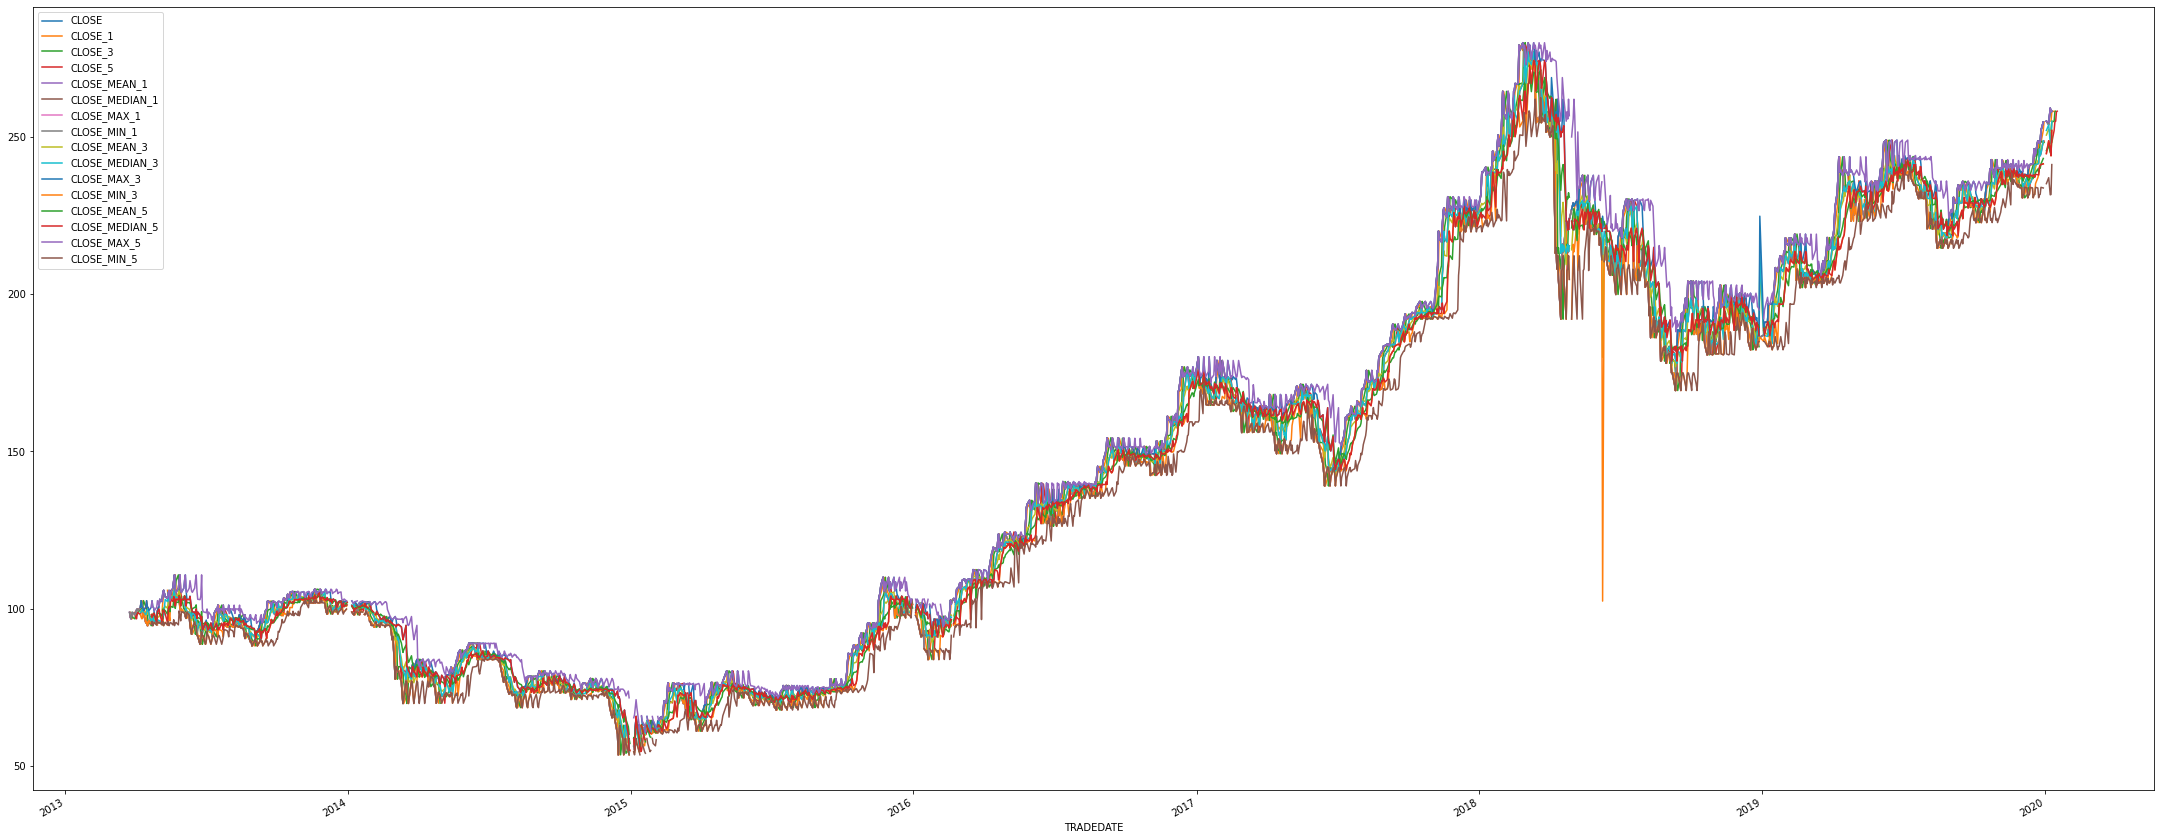

In [9]:
# Скользящие статистики ['mean', 'median', 'max', 'min', 'std'] с окнами 1, 3, 5 сгрупированные по дням недели
sber['WEEKDAY'] = sber.index.weekday
for window in [1, 3, 5]:
  sber = pd.merge(sber, sber.groupby('WEEKDAY')['CLOSE'].transform(lambda x: x.rolling(window=window).mean()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MEAN_{window}'))
  sber = pd.merge(sber, sber.groupby('WEEKDAY')['CLOSE'].transform(lambda x: x.rolling(window=window).median()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MEDIAN_{window}'))
  sber = pd.merge(sber, sber.groupby('WEEKDAY')['CLOSE'].transform(lambda x: x.rolling(window=window).max()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MAX_{window}'))
  sber = pd.merge(sber, sber.groupby('WEEKDAY')['CLOSE'].transform(lambda x: x.rolling(window=window).min()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MIN_{window}'))
  sber = pd.merge(sber, sber.groupby('WEEKDAY')['CLOSE'].transform(lambda x: x.rolling(window=window).std()), how='outer', left_index=True, right_index=True, suffixes=('', f'_STD_{window}'))
sber[['CLOSE', 'CLOSE_1',	'CLOSE_3',	'CLOSE_5', 'CLOSE_MEAN_1',	'CLOSE_MEDIAN_1',	'CLOSE_MAX_1', 'CLOSE_MIN_1',	'CLOSE_MEAN_3',	'CLOSE_MEDIAN_3',	'CLOSE_MAX_3',	'CLOSE_MIN_3',	
      'CLOSE_MEAN_5',	'CLOSE_MEDIAN_5',	'CLOSE_MAX_5',	'CLOSE_MIN_5']].plot(figsize=(38, 16))

In [10]:
# Статистики ['mean', 'median', 'max', 'min', 'std'] в расширяющемся окне сгруппированные по рабочим, праздничным и предпраздничным дням
sber = sber.merge(onehot_calendar['Выходной'], how='left', left_index=True, right_index=True)
sber = sber.merge(onehot_calendar['Праздник'], how='left', left_index=True, right_index=True)
sber = sber.merge(onehot_calendar['Предпраздничный рабочий день'], how='left', left_index=True, right_index=True)
for day in ['Выходной', 'Праздник', 'Предпраздничный рабочий день']:
  sber = pd.merge(sber, sber.groupby(day)['CLOSE'].transform(lambda x: x.expanding().mean()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MEAN_{day}'))
  sber = pd.merge(sber, sber.groupby(day)['CLOSE'].transform(lambda x: x.expanding().median()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MEDIAN_{day}'))
  sber = pd.merge(sber, sber.groupby(day)['CLOSE'].transform(lambda x: x.expanding().max()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MAX_{day}'))
  sber = pd.merge(sber, sber.groupby(day)['CLOSE'].transform(lambda x: x.expanding().min()), how='outer', left_index=True, right_index=True, suffixes=('', f'_MIN_{day}'))
  sber = pd.merge(sber, sber.groupby(day)['CLOSE'].transform(lambda x: x.expanding().std()), how='outer', left_index=True, right_index=True, suffixes=('', f'_STD_{day}'))

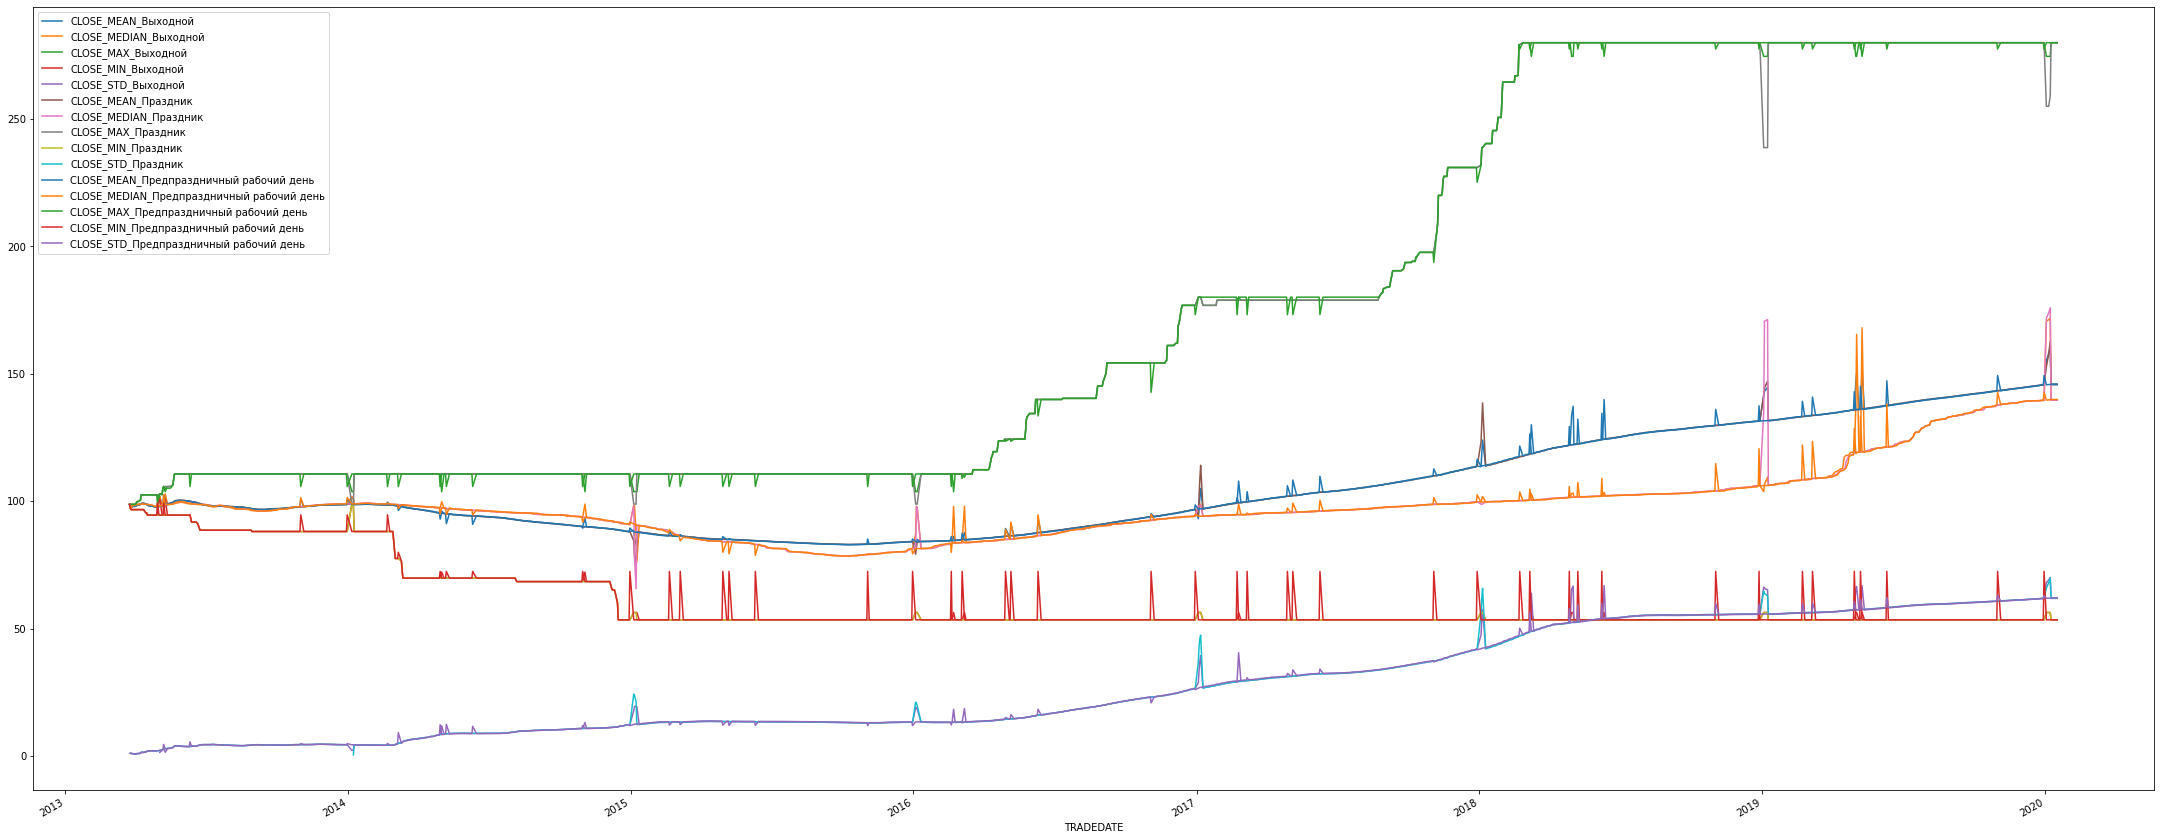

In [11]:
sber[['CLOSE_MEAN_Выходной',	'CLOSE_MEDIAN_Выходной',	'CLOSE_MAX_Выходной',	'CLOSE_MIN_Выходной',	'CLOSE_STD_Выходной', 'CLOSE_MEAN_Праздник',	'CLOSE_MEDIAN_Праздник',	'CLOSE_MAX_Праздник',	'CLOSE_MIN_Праздник',	'CLOSE_STD_Праздник',	
      'CLOSE_MEAN_Предпраздничный рабочий день',	'CLOSE_MEDIAN_Предпраздничный рабочий день',	'CLOSE_MAX_Предпраздничный рабочий день',	'CLOSE_MIN_Предпраздничный рабочий день', 'CLOSE_STD_Предпраздничный рабочий день']].plot(figsize=(38, 16))